# RNN


### Import thư viện


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from typing import Tuple

## ETH Dataset


### Import csv


In [2]:
# Đọc file ETH
file_path = "D:\\github_desktop\\Cryptocurrency-Price-Prediction\\Cryptocurrency\\Dataset\\Ethereum Historical Data.csv"

data = pd.read_csv(file_path)

# Loại bỏ dấu phẩy và chuyển đổi thành float cho Price và Open
for col in ['Price', 'Open']:
    data[col] = data[col].str.replace(',', '', regex=False).astype(float)

# Xử lý cột 'Vol.' chứa hậu tố 'K', 'M', 'B' thành số thực
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        try:
            return float(val)
        except ValueError:
            return np.nan  # Trường hợp val là '' hoặc không chuyển được

data['Vol.'] = data['Vol.'].apply(convert_volume)

# Kiểm tra NaN ban đầu trong Vol.
print(f"Trước khi xử lý, số NaN ở Vol.: {data['Vol.'].isna().sum()}")

# Nội suy giá trị Vol. (chỉ sau khi đã convert sang số)
data['Vol.'] = data['Vol.'].interpolate(mdataod='linear')

# Điền 0 cho NaN còn lại
data['Vol.'] = data['Vol.'].fillna(0)

# Kiểm tra NaN sau xử lý
print(f"Sau khi xử lý, số NaN ở Vol.: {data['Vol.'].isna().sum()}")

# Đổi Date sang datetime và đặt làm index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Thông tin dữ liệu
print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nFirst 5 rows:")
print(data[['Price', 'Open', 'Vol.']].head())

print(f"Tổng số dữ liệu: {len(data)} dòng")

Trước khi xử lý, số NaN ở Vol.: 8
Sau khi xử lý, số NaN ở Vol.: 0
Data shape: (3370, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
            Price   Open     Vol.
Date                             
2016-03-10  11.75  11.20      0.0
2016-03-11  11.95  11.75    180.0
2016-03-12  12.92  11.95    830.0
2016-03-13  15.07  12.92   1300.0
2016-03-14  12.50  15.07  92180.0
Tổng số dữ liệu: 3370 dòng


### Chia 7:3


#### Chuẩn hóa dữ liệu


In [3]:
# Chuẩn hóa dữ liệu
# Lấy 3 cột Price, Open, Vol. để làm đầu vào và Price làm đầu ra
input_features = data[['Price', 'Open', 'Vol.']].values
target_feature = data[['Price']].values

# Áp dụng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Áp dụng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

In [4]:
# Chia dữ liệu train/test theo tỷ lệ 7:3
train_size = int(len(data) * 0.7)
train_data = data.iloc[0:train_size,:]
test_data = data.iloc[train_size:len(data),:]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input = scaled_input[0:train_size,:]
scaled_test_input = scaled_input[train_size:,:]
scaled_train_target = scaled_target[0:train_size,:]
scaled_test_target = scaled_target[train_size:,:]

print(f"Kích thước tập train: {len(train_data)}")
print(f"Kích thước tập test: {len(test_data)}")

Kích thước tập train: 2359
Kích thước tập test: 1011


#### Xây dựng mô hình RNN


In [5]:
def build_rnn_model_with_regularization(time_step: int, num_features: int) -> Sequential:
    """
    Xây dựng mô hình RNN với regularization

    Args:
        time_step: Số time steps để nhìn về quá khứ
        num_features: Số features đầu vào (Price, Open, Vol = 3)

    Returns:
        Sequential model
    """
    model = Sequential()

    # SimpleRNN layer với regularization
    model.add(SimpleRNN(
        units=100,                       # Số neurons
        input_shape=(time_step, num_features),  # (50, 3)
        kernel_regularizer=regularizers.l2(0.001),    # L2 regularization
        return_sequences=False           # Chỉ cần output cuối cùng
    ))

    # Dropout để tránh overfitting
    model.add(Dropout(0.3))

    # Dense layer ẩn
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer: dự đoán 1 giá trị (Price)
    model.add(Dense(1))

    # Optimizer với learning rate nhỏ
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [6]:
# Hàm tạo dữ liệu time series với multiple features
def create_multivariate_time_series_data(input_data: np.ndarray, target_data: np.ndarray, time_step: int) -> Tuple[np.ndarray, np.ndarray]:
    X_data, y_data = [], []
    for i in range(len(input_data) - time_step):
        X_data.append(input_data[i:(i + time_step), :])  # Lấy tất cả features
        y_data.append(target_data[i + time_step, 0])     # Chỉ lấy Price
    return np.array(X_data), np.array(y_data)

In [7]:
# Hàm dự đoán với multiple features
def forecast_multivariate_prices(model: Sequential, input_data: np.ndarray, time_step: int,
                                forecast_days: int, scaler_target: MinMaxScaler) -> np.ndarray:
    temp_input = input_data[-time_step:].reshape(1, time_step, input_data.shape[1])
    lst_output = []

    for _ in range(forecast_days):
        predicted_price = model.predict(temp_input, verbose=0)
        lst_output.append(predicted_price[0].tolist())

        # Tạo input mới cho prediction tiếp theo
        # Giả sử các features khác không đổi, chỉ cập nhật Price
        new_row = temp_input[0, -1, :].copy()
        new_row[0] = predicted_price[0, 0]  # Cập nhật Price prediction

        temp_input = np.append(temp_input[:, 1:, :],
                              new_row.reshape(1, 1, input_data.shape[1]), axis=1)

    # Chuyển đổi lst_output thành numpy array và inverse transform
    lst_output = np.array(lst_output).reshape(-1, 1)
    return scaler_target.inverse_transform(lst_output)

#### Huấn luyện mô hình


In [8]:
# Tạo dữ liệu train và test với time_step = 50
time_step = 50
X_train, y_train = create_multivariate_time_series_data(scaled_train_input, scaled_train_target, time_step)
X_test, y_test = create_multivariate_time_series_data(scaled_test_input, scaled_test_target, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Xây dựng mô hình RNN
model_rnn = build_rnn_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks để tối ưu hóa
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=60,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

X_train shape: (2309, 50, 3)
y_train shape: (2309,)
X_test shape: (961, 50, 3)
y_test shape: (961,)
Epoch 1/60


c:\Users\Hii\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0630 - mae: 0.1202 - val_loss: 0.0174 - val_mae: 0.0969 - learning_rate: 1.0000e-04
Epoch 2/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0179 - mae: 0.0535 - val_loss: 0.0075 - val_mae: 0.0273 - learning_rate: 1.0000e-04
Epoch 3/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129 - mae: 0.0419 - val_loss: 0.0083 - val_mae: 0.0371 - learning_rate: 1.0000e-04
Epoch 4/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0119 - mae: 0.0390 - val_loss: 0.0070 - val_mae: 0.0207 - learning_rate: 1.0000e-04
Epoch 5/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - mae: 0.0352 - val_loss: 0.0086 - val_mae: 0.0430 - learning_rate: 1.0000e-04
Epoch 6/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112 - mae: 0.0361 - val_loss: 0.0078 - val_mae: 0.0334 - learning_rate: 1.0000e-04
Epoch 7/60
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - mae: 0.0350 - val_loss: 0.0066 - val_mae: 0.0179 - learning_rate: 

#### Đánh giá mô hình


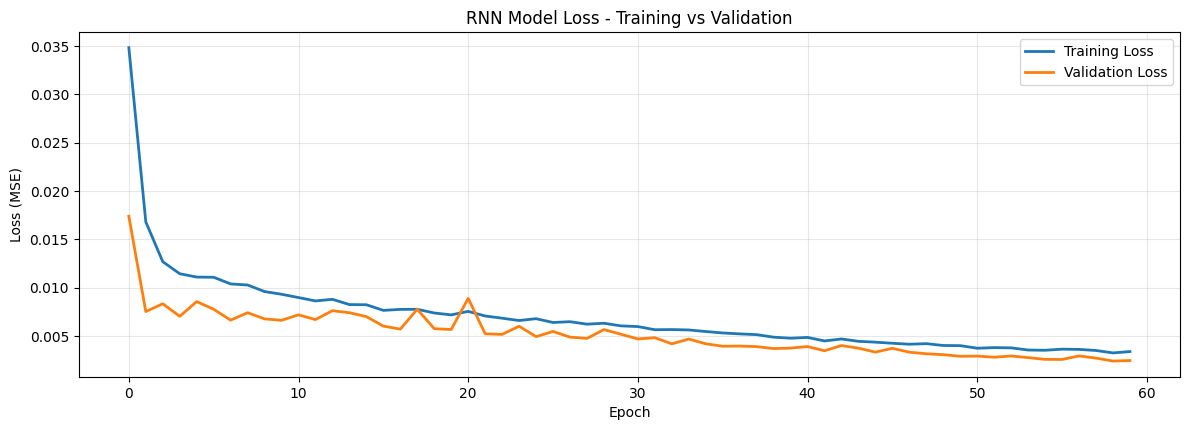

Epoch tốt nhất: 59 với val_loss: 0.002411


In [9]:
# Vẽ val_loss để đánh giá overfitting
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_rnn.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_rnn.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('RNN Model Loss - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất
best_epoch = np.argmin(history_rnn.history['val_loss']) + 1
best_val_loss = min(history_rnn.history['val_loss'])
print(f"Epoch tốt nhất: {best_epoch} với val_loss: {best_val_loss:.6f}")

#### Dự đoán và trực quan hóa


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


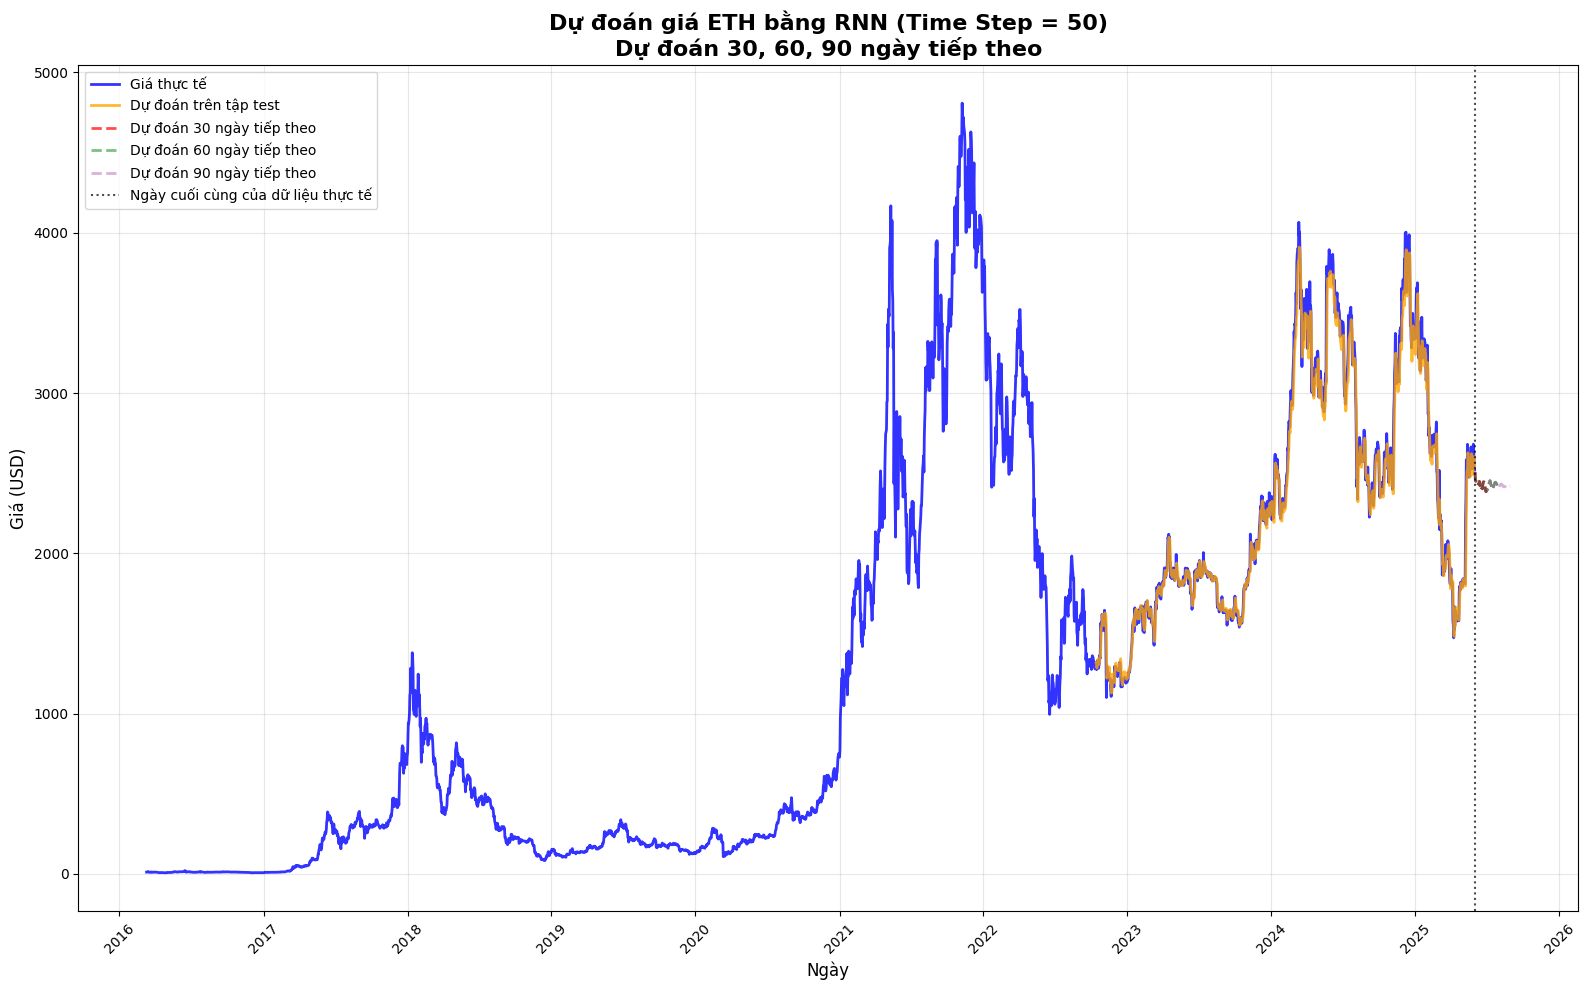

In [10]:
# Dự đoán 30, 60, 90 ngày tiếp theo
last_data_scaled = scaled_test_input[-time_step:]

forecasted_prices_30 = forecast_multivariate_prices(model_rnn, last_data_scaled, time_step, 30, scaler_target)
forecasted_prices_60 = forecast_multivariate_prices(model_rnn, last_data_scaled, time_step, 60, scaler_target)
forecasted_prices_90 = forecast_multivariate_prices(model_rnn, last_data_scaled, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra
test_predict_scaled = model_rnn.predict(X_test)
test_predict_rnn = scaler_target.inverse_transform(test_predict_scaled)

# Tạo DataFrame cho các dự đoán
forecast_dates_30 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30 = pd.DataFrame(forecasted_prices_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecasted_prices_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecasted_prices_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa kết quả
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(data.index, data['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test
plt.plot(test_data.index[time_step:], test_predict_rnn,
         label='Dự đoán trên tập test', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'],
         label='Dự đoán 30 ngày tiếp theo', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60.index, forecast_df_60['Price'],
         label='Dự đoán 60 ngày tiếp theo', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90.index, forecast_df_90['Price'],
         label='Dự đoán 90 ngày tiếp theo', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=data.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá ETH bằng RNN (Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Đánh giá mô hình
# Lấy giá trị thực tế trên tập test
y_test_actual = test_data['Price'].values[time_step:]

# Tính toán các metrics
mape = mean_absolute_percentage_error(y_test_actual, test_predict_rnn.flatten())
mse = mean_squared_error(y_test_actual, test_predict_rnn.flatten())
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình RNN (Time Step = {time_step}):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Số epochs huấn luyện: {len(history_rnn.history["loss"])}')

# Hiển thị thông tin dự đoán 30 ngày
print(f'\nDự đoán giá ETH 30 ngày tiếp theo:')
print(f'Giá cao nhất: ${forecasted_prices_30.max():.2f}')
print(f'Giá thấp nhất: ${forecasted_prices_30.min():.2f}')
print(f'Giá trung bình: ${forecasted_prices_30.mean():.2f}')

Kết quả đánh giá mô hình RNN (Time Step = 50):
MAPE: 0.03%
MSE: 9397.16
RMSE: 96.94
Số epochs huấn luyện: 60

Dự đoán giá ETH 30 ngày tiếp theo:
Giá cao nhất: $2506.44
Giá thấp nhất: $2384.23
Giá trung bình: $2429.11


### Chia 8:2


#### Chuẩn hóa dữ liệu 8:2


In [12]:
# Chuẩn hóa dữ liệu
# Lấy 3 cột Price, Open, Vol. để làm đầu vào và Price làm đầu ra
input_features = data[['Price', 'Open', 'Vol.']].values
target_feature = data[['Price']].values

# Áp dụng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Áp dụng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

In [13]:
# Chia dữ liệu train/test theo tỷ lệ 8:2
train_size_82 = int(len(data) * 0.8)
train_data_82 = data.iloc[0:train_size_82,:]
test_data_82 = data.iloc[train_size_82:len(data),:]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input_82 = scaled_input[0:train_size_82,:]
scaled_test_input_82 = scaled_input[train_size_82:,:]
scaled_train_target_82 = scaled_target[0:train_size_82,:]
scaled_test_target_82 = scaled_target[train_size_82:,:]

print(f"Kích thước tập train 8:2: {len(train_data_82)}")
print(f"Kích thước tập test 8:2: {len(test_data_82)}")

Kích thước tập train 8:2: 2696
Kích thước tập test 8:2: 674


#### Xây dựng mô hình RNN


In [14]:
def build_rnn_model_with_regularization(time_step: int, num_features: int) -> Sequential:
    """
    Xây dựng mô hình RNN với regularization

    Args:
        time_step: Số time steps để nhìn về quá khứ
        num_features: Số features đầu vào (Price, Open, Vol = 3)

    Returns:
        Sequential model
    """
    model = Sequential()

    # SimpleRNN layer với regularization
    model.add(SimpleRNN(
        units=100,                       # Số neurons
        input_shape=(time_step, num_features),  # (50, 3)
        kernel_regularizer=regularizers.l2(0.001),    # L2 regularization
        return_sequences=False           # Chỉ cần output cuối cùng
    ))

    # Dropout để tránh overfitting
    model.add(Dropout(0.3))

    # Dense layer ẩn
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer: dự đoán 1 giá trị (Price)
    model.add(Dense(1))

    # Optimizer với learning rate nhỏ
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [15]:
# Hàm tạo dữ liệu time series với multiple features
def create_multivariate_time_series_data(input_data: np.ndarray, target_data: np.ndarray, time_step: int) -> Tuple[np.ndarray, np.ndarray]:
    X_data, y_data = [], []
    for i in range(len(input_data) - time_step):
        X_data.append(input_data[i:(i + time_step), :])  # Lấy tất cả features
        y_data.append(target_data[i + time_step, 0])     # Chỉ lấy Price
    return np.array(X_data), np.array(y_data)

In [16]:
# Hàm dự đoán với multiple features
def forecast_multivariate_prices(model: Sequential, input_data: np.ndarray, time_step: int,
                                forecast_days: int, scaler_target: MinMaxScaler) -> np.ndarray:
    temp_input = input_data[-time_step:].reshape(1, time_step, input_data.shape[1])
    lst_output = []

    for _ in range(forecast_days):
        predicted_price = model.predict(temp_input, verbose=0)
        lst_output.append(predicted_price[0].tolist())

        # Tạo input mới cho prediction tiếp theo
        # Giả sử các features khác không đổi, chỉ cập nhật Price
        new_row = temp_input[0, -1, :].copy()
        new_row[0] = predicted_price[0, 0]  # Cập nhật Price prediction

        temp_input = np.append(temp_input[:, 1:, :],
                              new_row.reshape(1, 1, input_data.shape[1]), axis=1)

    # Chuyển đổi lst_output thành numpy array và inverse transform
    lst_output = np.array(lst_output).reshape(-1, 1)
    return scaler_target.inverse_transform(lst_output)

#### Huấn luyện mô hình 8:2


In [17]:
# Tạo dữ liệu train và test với time_step = 50 cho split 8:2
X_train_82, y_train_82 = create_multivariate_time_series_data(scaled_train_input_82, scaled_train_target_82, time_step)
X_test_82, y_test_82 = create_multivariate_time_series_data(scaled_test_input_82, scaled_test_target_82, time_step)

print(f"X_train_82 shape: {X_train_82.shape}")
print(f"y_train_82 shape: {y_train_82.shape}")
print(f"X_test_82 shape: {X_test_82.shape}")
print(f"y_test_82 shape: {y_test_82.shape}")

# Xây dựng mô hình RNN cho split 8:2
model_rnn_82 = build_rnn_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks để tối ưu hóa
early_stop_82 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr_82 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình 8:2
history_rnn_82 = model_rnn_82.fit(
    X_train_82, y_train_82,
    epochs=60,
    batch_size=16,
    validation_data=(X_test_82, y_test_82),
    callbacks=[early_stop_82, reduce_lr_82],
    verbose=1
)

X_train_82 shape: (2646, 50, 3)
y_train_82 shape: (2646,)
X_test_82 shape: (624, 50, 3)
y_test_82 shape: (624,)
Epoch 1/60


c:\Users\Hii\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0585 - mae: 0.1190 - val_loss: 0.0088 - val_mae: 0.0459 - learning_rate: 1.0000e-04
Epoch 2/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0120 - mae: 0.0450 - val_loss: 0.0074 - val_mae: 0.0342 - learning_rate: 1.0000e-04
Epoch 3/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0113 - mae: 0.0410 - val_loss: 0.0068 - val_mae: 0.0272 - learning_rate: 1.0000e-04
Epoch 4/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0094 - mae: 0.0352 - val_loss: 0.0132 - val_mae: 0.0822 - learning_rate: 1.0000e-04
Epoch 5/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096 - mae: 0.0352 - val_loss: 0.0075 - val_mae: 0.0381 - learning_rate: 1.0000e-04
Epoch 6/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - mae: 0.0362 - val_loss: 0.0065 - val_mae: 0.0288 - learning_rate: 1.0000e-04
Epoch 7/60
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - mae: 0.0338 - val_loss: 0.0077 - val_mae: 0.0440 - learning_rate: 

#### Đánh giá mô hình 8:2


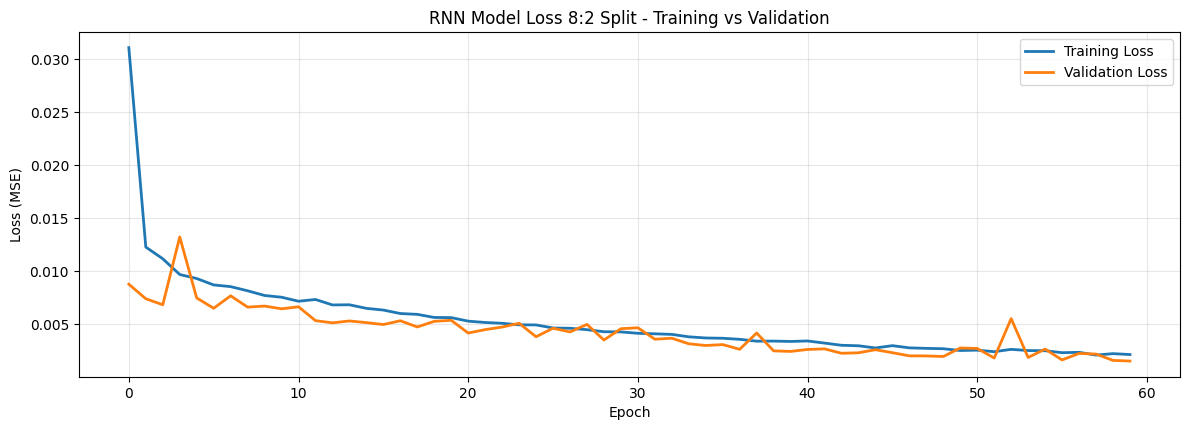

Epoch tốt nhất (8:2): 60 với val_loss: 0.001537


In [18]:
# Vẽ val_loss để đánh giá overfitting cho split 8:2
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_rnn_82.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_rnn_82.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('RNN Model Loss 8:2 Split - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất cho split 8:2
best_epoch_82 = np.argmin(history_rnn_82.history['val_loss']) + 1
best_val_loss_82 = min(history_rnn_82.history['val_loss'])
print(f"Epoch tốt nhất (8:2): {best_epoch_82} với val_loss: {best_val_loss_82:.6f}")

#### Dự đoán và trực quan hóa 8:2


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


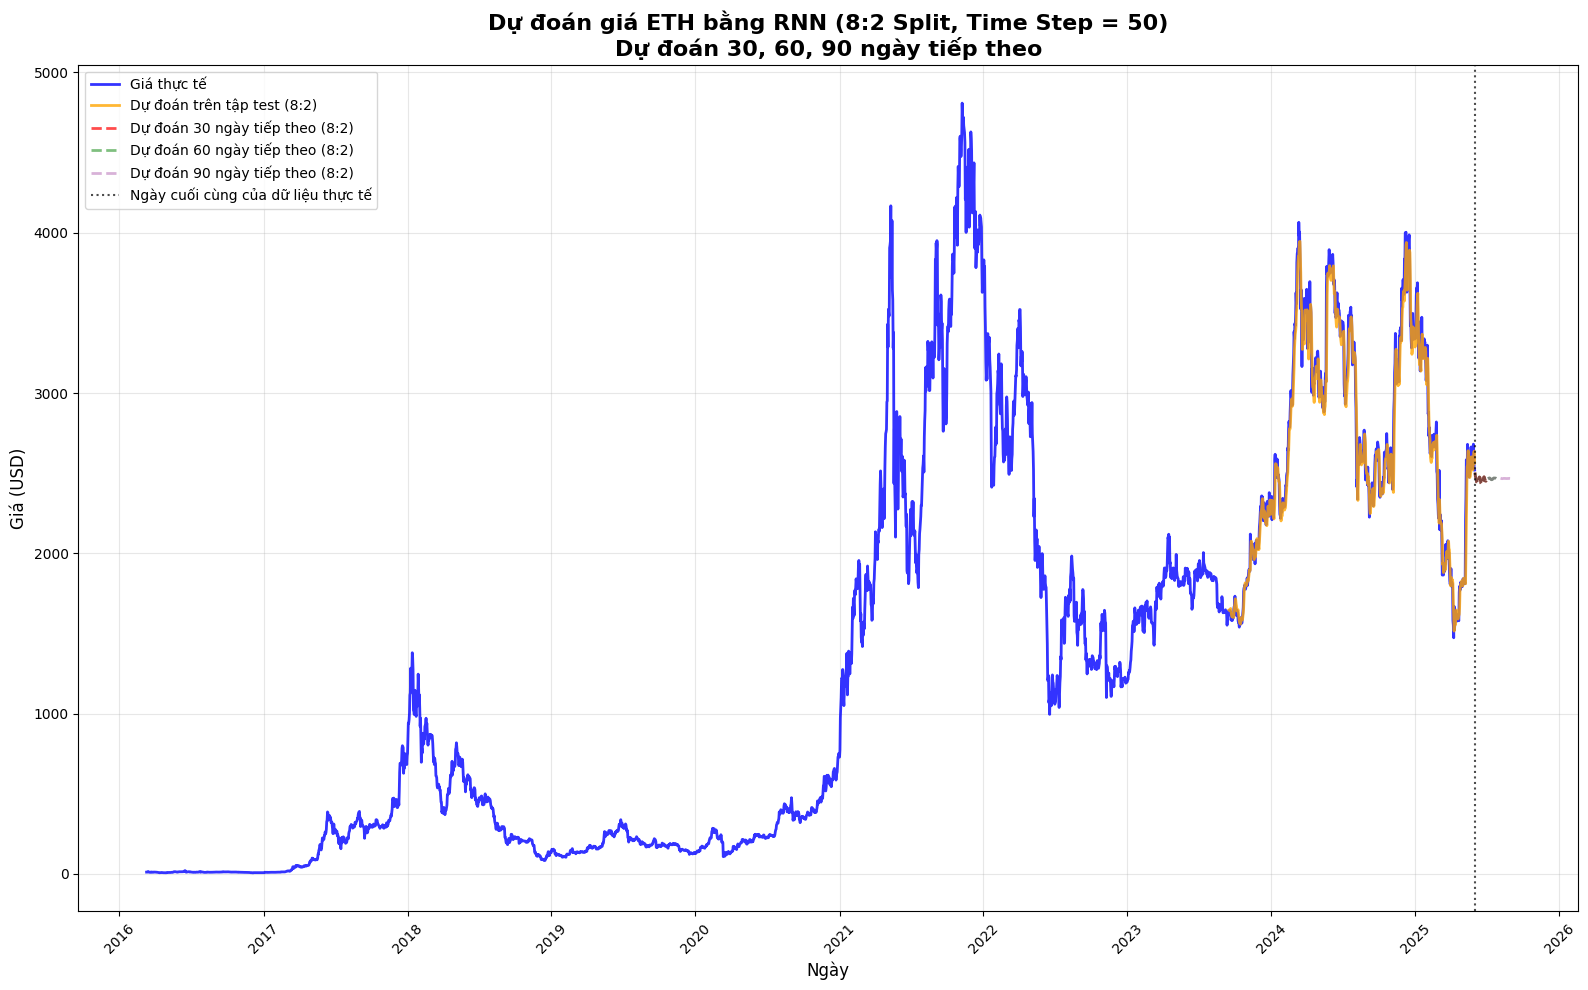

In [19]:
# Dự đoán 30, 60, 90 ngày tiếp theo cho split 8:2
last_data_scaled_82 = scaled_test_input_82[-time_step:]

forecasted_prices_30_82 = forecast_multivariate_prices(model_rnn_82, last_data_scaled_82, time_step, 30, scaler_target)
forecasted_prices_60_82 = forecast_multivariate_prices(model_rnn_82, last_data_scaled_82, time_step, 60, scaler_target)
forecasted_prices_90_82 = forecast_multivariate_prices(model_rnn_82, last_data_scaled_82, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra cho split 8:2
test_predict_scaled_82 = model_rnn_82.predict(X_test_82)
test_predict_rnn_82 = scaler_target.inverse_transform(test_predict_scaled_82)

# Tạo DataFrame cho các dự đoán 8:2
forecast_dates_30_82 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60_82 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90_82 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30_82 = pd.DataFrame(forecasted_prices_30_82, index=forecast_dates_30_82, columns=['Price'])
forecast_df_60_82 = pd.DataFrame(forecasted_prices_60_82, index=forecast_dates_60_82, columns=['Price'])
forecast_df_90_82 = pd.DataFrame(forecasted_prices_90_82, index=forecast_dates_90_82, columns=['Price'])

# Trực quan hóa kết quả cho split 8:2
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(data.index, data['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test 8:2
plt.plot(test_data_82.index[time_step:], test_predict_rnn_82,
         label='Dự đoán trên tập test (8:2)', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai 8:2
plt.plot(forecast_df_30_82.index, forecast_df_30_82['Price'],
         label='Dự đoán 30 ngày tiếp theo (8:2)', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60_82.index, forecast_df_60_82['Price'],
         label='Dự đoán 60 ngày tiếp theo (8:2)', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90_82.index, forecast_df_90_82['Price'],
         label='Dự đoán 90 ngày tiếp theo (8:2)', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=data.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá ETH bằng RNN (8:2 Split, Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Đánh giá mô hình 8:2
# Lấy giá trị thực tế trên tập test 8:2
y_test_actual_82 = test_data_82['Price'].values[time_step:]

# Tính toán các metrics cho split 8:2
mape_82 = mean_absolute_percentage_error(y_test_actual_82, test_predict_rnn_82.flatten())
mse_82 = mean_squared_error(y_test_actual_82, test_predict_rnn_82.flatten())
rmse_82 = np.sqrt(mse_82)

print(f'Kết quả đánh giá mô hình RNN 8:2 Split (Time Step = {time_step}):')
print(f'MAPE: {mape_82:.2f}%')
print(f'MSE: {mse_82:.2f}')
print(f'RMSE: {rmse_82:.2f}')
print(f'Số epochs huấn luyện: {len(history_rnn_82.history["loss"])}')

# Hiển thị thông tin dự đoán 30 ngày cho 8:2
print(f'\nDự đoán giá ETH 30 ngày tiếp theo (8:2):')
print(f'Giá cao nhất: ${forecasted_prices_30_82.max():.2f}')
print(f'Giá thấp nhất: ${forecasted_prices_30_82.min():.2f}')
print(f'Giá trung bình: ${forecasted_prices_30_82.mean():.2f}')

Kết quả đánh giá mô hình RNN 8:2 Split (Time Step = 50):
MAPE: 0.03%
MSE: 12488.07
RMSE: 111.75
Số epochs huấn luyện: 60

Dự đoán giá ETH 30 ngày tiếp theo (8:2):
Giá cao nhất: $2503.17
Giá thấp nhất: $2434.53
Giá trung bình: $2458.25


### Chia 9:1


#### Chuẩn hóa dữ liệu 9:1


In [21]:
# Chuẩn hóa dữ liệu
# Lấy 3 cột Price, Open, Vol. để làm đầu vào và Price làm đầu ra
input_features = data[['Price', 'Open', 'Vol.']].values
target_feature = data[['Price']].values

# Áp dụng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Áp dụng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

In [22]:
# Chia dữ liệu train/test theo tỷ lệ 9:1
train_size_91 = int(len(data) * 0.9)
train_data_91 = data.iloc[0:train_size_91,:]
test_data_91 = data.iloc[train_size_91:len(data),:]

# Chia dữ liệu đã chuẩn hóa
scaled_train_input_91 = scaled_input[0:train_size_91,:]
scaled_test_input_91 = scaled_input[train_size_91:,:]
scaled_train_target_91 = scaled_target[0:train_size_91,:]
scaled_test_target_91 = scaled_target[train_size_91:,:]

print(f"Kích thước tập train 9:1: {len(train_data_91)}")
print(f"Kích thước tập test 9:1: {len(test_data_91)}")

Kích thước tập train 9:1: 3033
Kích thước tập test 9:1: 337


#### Xây dựng mô hình RNN


In [23]:
def build_rnn_model_with_regularization(time_step: int, num_features: int) -> Sequential:
    """
    Xây dựng mô hình RNN với regularization

    Args:
        time_step: Số time steps để nhìn về quá khứ
        num_features: Số features đầu vào (Price, Open, Vol = 3)

    Returns:
        Sequential model
    """
    model = Sequential()

    # SimpleRNN layer với regularization
    model.add(SimpleRNN(
        units=100,                       # Số neurons
        input_shape=(time_step, num_features),  # (50, 3)
        kernel_regularizer=regularizers.l2(0.001),    # L2 regularization
        return_sequences=False           # Chỉ cần output cuối cùng
    ))

    # Dropout để tránh overfitting
    model.add(Dropout(0.3))

    # Dense layer ẩn
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer: dự đoán 1 giá trị (Price)
    model.add(Dense(1))

    # Optimizer với learning rate nhỏ
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [24]:
# Hàm tạo dữ liệu time series với multiple features
def create_multivariate_time_series_data(input_data: np.ndarray, target_data: np.ndarray, time_step: int) -> Tuple[np.ndarray, np.ndarray]:
    X_data, y_data = [], []
    for i in range(len(input_data) - time_step):
        X_data.append(input_data[i:(i + time_step), :])  # Lấy tất cả features
        y_data.append(target_data[i + time_step, 0])     # Chỉ lấy Price
    return np.array(X_data), np.array(y_data)

In [25]:
# Hàm dự đoán với multiple features
def forecast_multivariate_prices(model: Sequential, input_data: np.ndarray, time_step: int,
                                forecast_days: int, scaler_target: MinMaxScaler) -> np.ndarray:
    temp_input = input_data[-time_step:].reshape(1, time_step, input_data.shape[1])
    lst_output = []

    for _ in range(forecast_days):
        predicted_price = model.predict(temp_input, verbose=0)
        lst_output.append(predicted_price[0].tolist())

        # Tạo input mới cho prediction tiếp theo
        # Giả sử các features khác không đổi, chỉ cập nhật Price
        new_row = temp_input[0, -1, :].copy()
        new_row[0] = predicted_price[0, 0]  # Cập nhật Price prediction

        temp_input = np.append(temp_input[:, 1:, :],
                              new_row.reshape(1, 1, input_data.shape[1]), axis=1)

    # Chuyển đổi lst_output thành numpy array và inverse transform
    lst_output = np.array(lst_output).reshape(-1, 1)
    return scaler_target.inverse_transform(lst_output)

#### Huấn luyện mô hình 9:1


In [26]:
# Tạo dữ liệu train và test với time_step = 50 cho split 9:1
X_train_91, y_train_91 = create_multivariate_time_series_data(scaled_train_input_91, scaled_train_target_91, time_step)
X_test_91, y_test_91 = create_multivariate_time_series_data(scaled_test_input_91, scaled_test_target_91, time_step)

print(f"X_train_91 shape: {X_train_91.shape}")
print(f"y_train_91 shape: {y_train_91.shape}")
print(f"X_test_91 shape: {X_test_91.shape}")
print(f"y_test_91 shape: {y_test_91.shape}")

# Xây dựng mô hình RNN cho split 9:1
model_rnn_91 = build_rnn_model_with_regularization(time_step, 3)  # 3 features: Price, Open, Vol

# Callbacks để tối ưu hóa
early_stop_91 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr_91 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)

# Huấn luyện mô hình 9:1
history_rnn_91 = model_rnn_91.fit(
    X_train_91, y_train_91,
    epochs=60,
    batch_size=16,
    validation_data=(X_test_91, y_test_91),
    callbacks=[early_stop_91, reduce_lr_91],
    verbose=1
)

X_train_91 shape: (2983, 50, 3)
y_train_91 shape: (2983,)
X_test_91 shape: (287, 50, 3)
y_test_91 shape: (287,)
Epoch 1/60


c:\Users\Hii\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0369 - mae: 0.0978 - val_loss: 0.0078 - val_mae: 0.0322 - learning_rate: 1.0000e-04
Epoch 2/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0129 - mae: 0.0494 - val_loss: 0.0087 - val_mae: 0.0420 - learning_rate: 1.0000e-04
Epoch 3/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - mae: 0.0408 - val_loss: 0.0147 - val_mae: 0.0878 - learning_rate: 1.0000e-04
Epoch 4/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - mae: 0.0382 - val_loss: 0.0072 - val_mae: 0.0312 - learning_rate: 1.0000e-04
Epoch 5/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097 - mae: 0.0369 - val_loss: 0.0094 - val_mae: 0.0531 - learning_rate: 1.0000e-04
Epoch 6/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0093 - mae: 0.0352 - val_loss: 0.0110 - val_mae: 0.0672 - learning_rate: 1.0000e-04
Epoch 7/60
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - mae: 0.0313 - val_loss: 0.0107 - val_mae: 0.0651 - learning_rate: 

#### Đánh giá mô hình 9:1


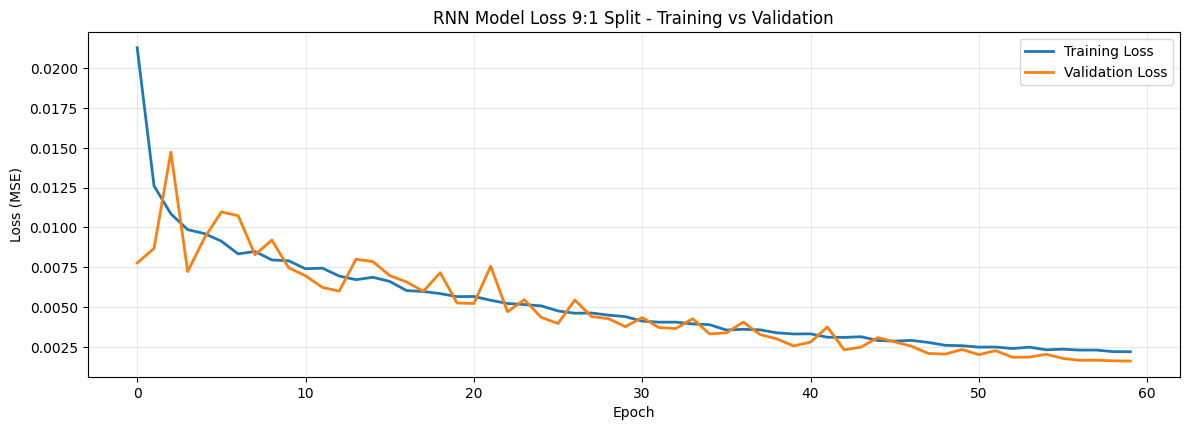

Epoch tốt nhất (9:1): 60 với val_loss: 0.001616


In [27]:
# Vẽ val_loss để đánh giá overfitting cho split 9:1
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_rnn_91.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_rnn_91.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('RNN Model Loss 9:1 Split - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm epoch có val_loss thấp nhất cho split 9:1
best_epoch_91 = np.argmin(history_rnn_91.history['val_loss']) + 1
best_val_loss_91 = min(history_rnn_91.history['val_loss'])
print(f"Epoch tốt nhất (9:1): {best_epoch_91} với val_loss: {best_val_loss_91:.6f}")

#### Dự đoán và trực quan hóa 9:1


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


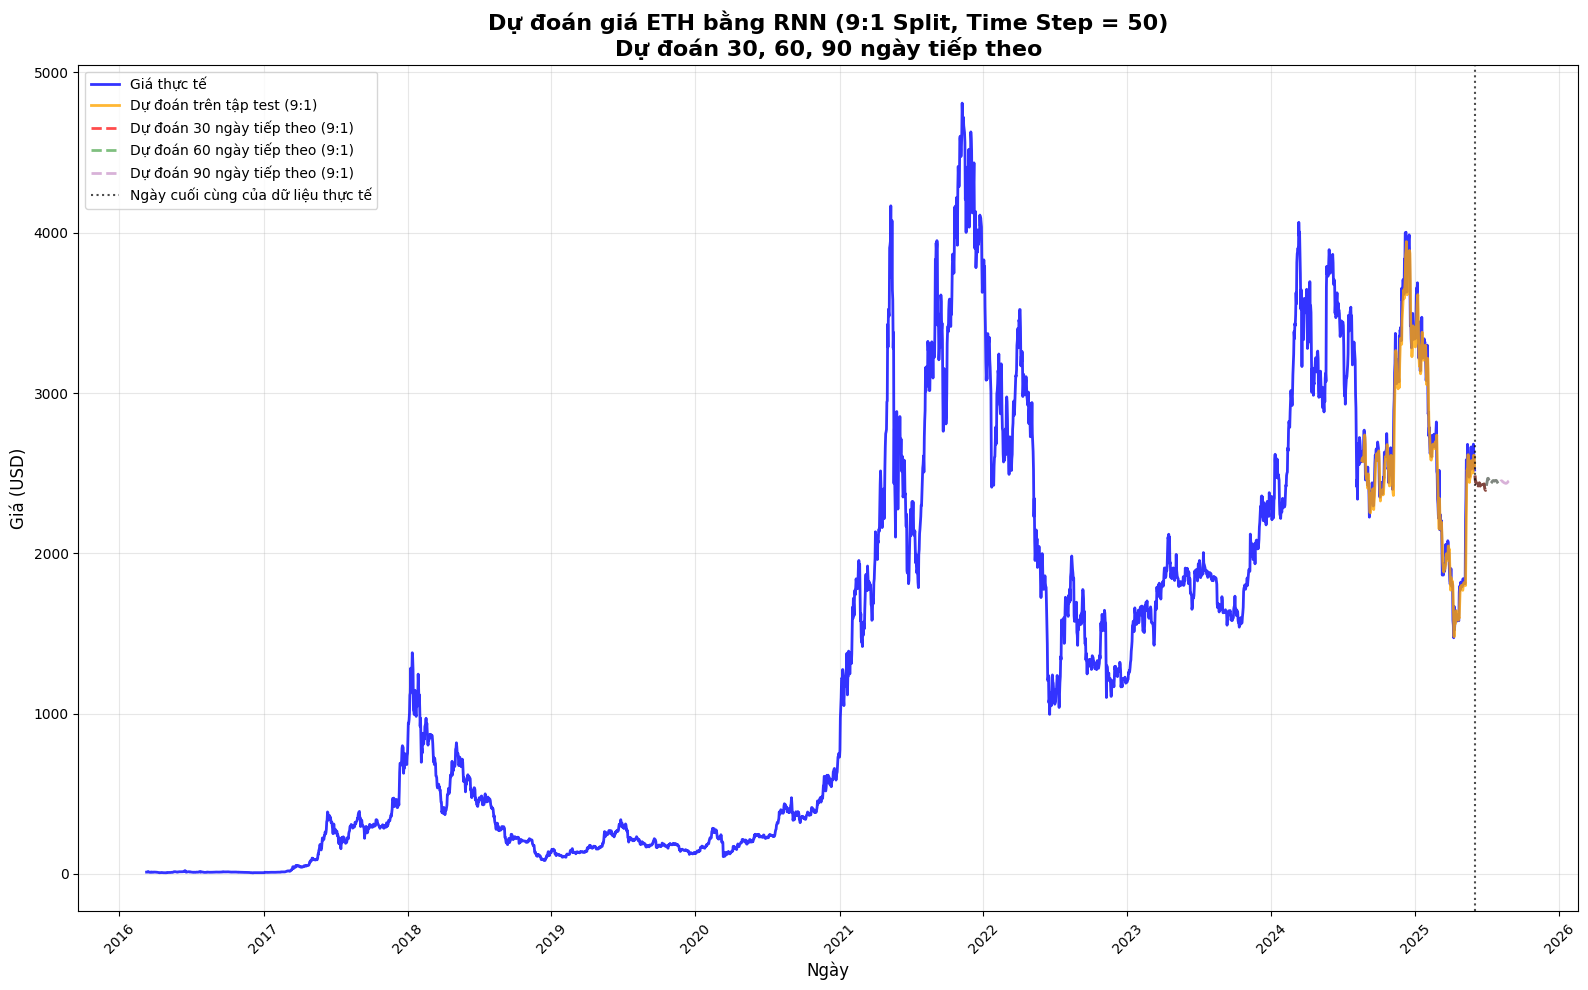

In [28]:
# Dự đoán 30, 60, 90 ngày tiếp theo cho split 9:1
last_data_scaled_91 = scaled_test_input_91[-time_step:]

forecasted_prices_30_91 = forecast_multivariate_prices(model_rnn_91, last_data_scaled_91, time_step, 30, scaler_target)
forecasted_prices_60_91 = forecast_multivariate_prices(model_rnn_91, last_data_scaled_91, time_step, 60, scaler_target)
forecasted_prices_90_91 = forecast_multivariate_prices(model_rnn_91, last_data_scaled_91, time_step, 90, scaler_target)

# Dự đoán giá trên tập kiểm tra cho split 9:1
test_predict_scaled_91 = model_rnn_91.predict(X_test_91)
test_predict_rnn_91 = scaler_target.inverse_transform(test_predict_scaled_91)

# Tạo DataFrame cho các dự đoán 9:1
forecast_dates_30_91 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60_91 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90_91 = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

forecast_df_30_91 = pd.DataFrame(forecasted_prices_30_91, index=forecast_dates_30_91, columns=['Price'])
forecast_df_60_91 = pd.DataFrame(forecasted_prices_60_91, index=forecast_dates_60_91, columns=['Price'])
forecast_df_90_91 = pd.DataFrame(forecasted_prices_90_91, index=forecast_dates_90_91, columns=['Price'])

# Trực quan hóa kết quả cho split 9:1
plt.figure(figsize=(16, 10))

# Vẽ giá thực tế
plt.plot(data.index, data['Price'], label='Giá thực tế', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán trên tập test 9:1
plt.plot(test_data_91.index[time_step:], test_predict_rnn_91,
         label='Dự đoán trên tập test (9:1)', color='orange', linewidth=2, alpha=0.8)

# Vẽ các dự đoán tương lai 9:1
plt.plot(forecast_df_30_91.index, forecast_df_30_91['Price'],
         label='Dự đoán 30 ngày tiếp theo (9:1)', color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.plot(forecast_df_60_91.index, forecast_df_60_91['Price'],
         label='Dự đoán 60 ngày tiếp theo (9:1)', color='green', linestyle='--', linewidth=2, alpha=0.5)

plt.plot(forecast_df_90_91.index, forecast_df_90_91['Price'],
         label='Dự đoán 90 ngày tiếp theo (9:1)', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Thêm đường thẳng đứng để phân biệt vùng dữ liệu
plt.axvline(x=data.index[-1], color='black', linestyle=':', alpha=0.7,
            label='Ngày cuối cùng của dữ liệu thực tế')

plt.title(f'Dự đoán giá ETH bằng RNN (9:1 Split, Time Step = {time_step})\nDự đoán 30, 60, 90 ngày tiếp theo',
          fontsize=16, fontweight='bold')
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
# Đánh giá mô hình 9:1
# Lấy giá trị thực tế trên tập test 9:1
y_test_actual_91 = test_data_91['Price'].values[time_step:]

# Tính toán các metrics cho split 9:1
mape_91 = mean_absolute_percentage_error(y_test_actual_91, test_predict_rnn_91.flatten())
mse_91 = mean_squared_error(y_test_actual_91, test_predict_rnn_91.flatten())
rmse_91 = np.sqrt(mse_91)

print(f'Kết quả đánh giá mô hình RNN 9:1 Split (Time Step = {time_step}):')
print(f'MAPE: {mape_91:.2f}%')
print(f'MSE: {mse_91:.2f}')
print(f'RMSE: {rmse_91:.2f}')
print(f'Số epochs huấn luyện: {len(history_rnn_91.history["loss"])}')

# Hiển thị thông tin dự đoán 30 ngày cho 9:1
print(f'\nDự đoán giá ETH 30 ngày tiếp theo (9:1):')
print(f'Giá cao nhất: ${forecasted_prices_30_91.max():.2f}')
print(f'Giá thấp nhất: ${forecasted_prices_30_91.min():.2f}')
print(f'Giá trung bình: ${forecasted_prices_30_91.mean():.2f}')

Kết quả đánh giá mô hình RNN 9:1 Split (Time Step = 50):
MAPE: 0.03%
MSE: 13481.85
RMSE: 116.11
Số epochs huấn luyện: 60

Dự đoán giá ETH 30 ngày tiếp theo (9:1):
Giá cao nhất: $2485.42
Giá thấp nhất: $2393.42
Giá trung bình: $2426.97


### So sánh 3 tỉ lệ


In [30]:
# So sánh chi tiết giữa 3 tỉ lệ chia dữ liệu
print("="*80)
print("SO SÁNH CHI TIẾT GIỮA 3 TỈ LỆ CHIA DỮ LIỆU")
print("="*80)

# Thu thập thông tin từ 3 splits
splits_info = {
    '7:3': {
        'train_size': len(train_data),
        'test_size': len(test_data),
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'epochs': len(history_rnn.history['loss']),
        'best_val_loss': best_val_loss,
        'best_epoch': best_epoch,
        'final_train_loss': history_rnn.history['loss'][-1],
        'final_val_loss': history_rnn.history['val_loss'][-1]
    },
    '8:2': {
        'train_size': len(train_data_82),
        'test_size': len(test_data_82),
        'mape': mape_82,
        'mse': mse_82,
        'rmse': rmse_82,
        'epochs': len(history_rnn_82.history['loss']),
        'best_val_loss': best_val_loss_82,
        'best_epoch': best_epoch_82,
        'final_train_loss': history_rnn_82.history['loss'][-1],
        'final_val_loss': history_rnn_82.history['val_loss'][-1]
    },
    '9:1': {
        'train_size': len(train_data_91),
        'test_size': len(test_data_91),
        'mape': mape_91,
        'mse': mse_91,
        'rmse': rmse_91,
        'epochs': len(history_rnn_91.history['loss']),
        'best_val_loss': best_val_loss_91,
        'best_epoch': best_epoch_91,
        'final_train_loss': history_rnn_91.history['loss'][-1],
        'final_val_loss': history_rnn_91.history['val_loss'][-1]
    }
}

# In bảng so sánh
for split, info in splits_info.items():
    print(f"\n{split} Split:")
    print(f"  Kích thước train: {info['train_size']:,} mẫu")
    print(f"  Kích thước test: {info['test_size']:,} mẫu")
    print(f"  MAPE: {info['mape']:.2f}%")
    print(f"  MSE: {info['mse']:,.2f}")
    print(f"  RMSE: {info['rmse']:,.2f}")
    print(f"  Số epochs: {info['epochs']}")
    print(f"  Best val_loss: {info['best_val_loss']:.6f} (epoch {info['best_epoch']})")
    print(f"  Final train_loss: {info['final_train_loss']:.6f}")
    print(f"  Final val_loss: {info['final_val_loss']:.6f}")
    print(f"  Overfitting gap: {abs(info['final_val_loss'] - info['final_train_loss']):.6f}")

SO SÁNH CHI TIẾT GIỮA 3 TỈ LỆ CHIA DỮ LIỆU

7:3 Split:
  Kích thước train: 2,359 mẫu
  Kích thước test: 1,011 mẫu
  MAPE: 0.03%
  MSE: 9,397.16
  RMSE: 96.94
  Số epochs: 60
  Best val_loss: 0.002411 (epoch 59)
  Final train_loss: 0.003393
  Final val_loss: 0.002463
  Overfitting gap: 0.000930

8:2 Split:
  Kích thước train: 2,696 mẫu
  Kích thước test: 674 mẫu
  MAPE: 0.03%
  MSE: 12,488.07
  RMSE: 111.75
  Số epochs: 60
  Best val_loss: 0.001537 (epoch 60)
  Final train_loss: 0.002151
  Final val_loss: 0.001537
  Overfitting gap: 0.000614

9:1 Split:
  Kích thước train: 3,033 mẫu
  Kích thước test: 337 mẫu
  MAPE: 0.03%
  MSE: 13,481.85
  RMSE: 116.11
  Số epochs: 60
  Best val_loss: 0.001616 (epoch 60)
  Final train_loss: 0.002203
  Final val_loss: 0.001616
  Overfitting gap: 0.000586


C:\Users\Hii\AppData\Local\Temp\ipykernel_3520\2283599594.py:62: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


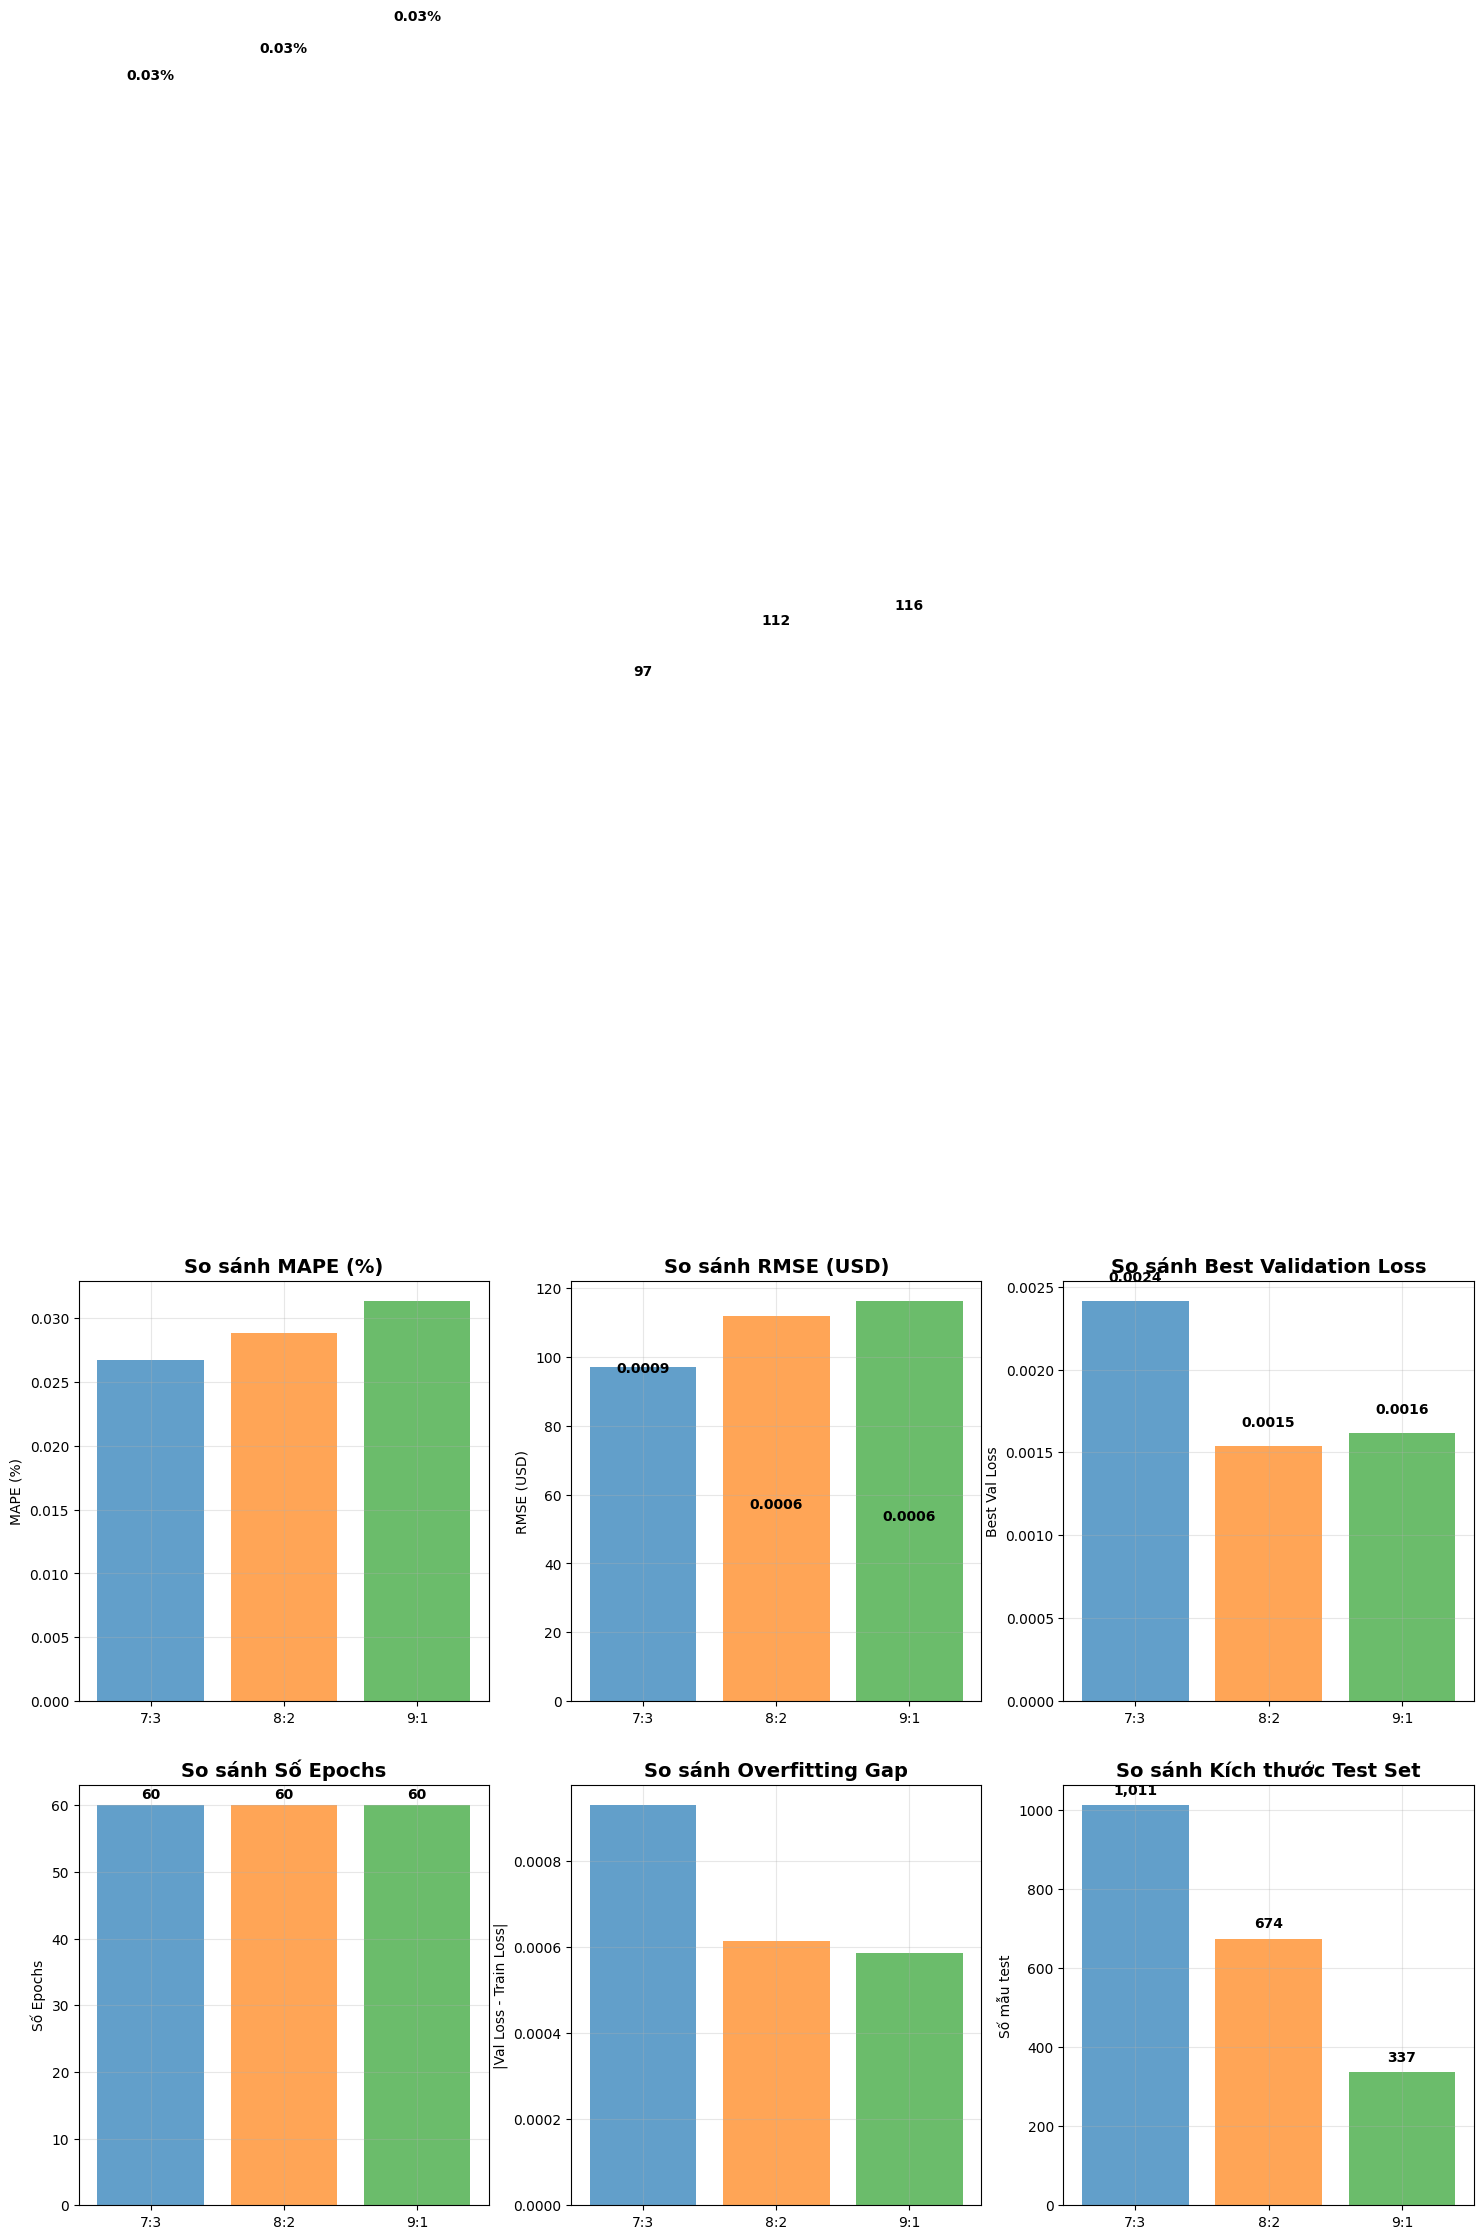

In [31]:
# Vẽ biểu đồ so sánh các metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

splits = ['7:3', '8:2', '9:1']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# 1. So sánh MAPE
mape_values = [splits_info[split]['mape'] for split in splits]
axes[0, 0].bar(splits, mape_values, color=colors, alpha=0.7)
axes[0, 0].set_title('So sánh MAPE (%)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('MAPE (%)')
axes[0, 0].grid(True, alpha=0.3)
for i, v in enumerate(mape_values):
    axes[0, 0].text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# 2. So sánh RMSE
rmse_values = [splits_info[split]['rmse'] for split in splits]
axes[0, 1].bar(splits, rmse_values, color=colors, alpha=0.7)
axes[0, 1].set_title('So sánh RMSE (USD)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('RMSE (USD)')
axes[0, 1].grid(True, alpha=0.3)
for i, v in enumerate(rmse_values):
    axes[0, 1].text(i, v + 200, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 3. So sánh Best Validation Loss
best_val_loss_values = [splits_info[split]['best_val_loss'] for split in splits]
axes[0, 2].bar(splits, best_val_loss_values, color=colors, alpha=0.7)
axes[0, 2].set_title('So sánh Best Validation Loss', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('Best Val Loss')
axes[0, 2].grid(True, alpha=0.3)
for i, v in enumerate(best_val_loss_values):
    axes[0, 2].text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 4. So sánh số epochs
epochs_values = [splits_info[split]['epochs'] for split in splits]
axes[1, 0].bar(splits, epochs_values, color=colors, alpha=0.7)
axes[1, 0].set_title('So sánh Số Epochs', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Số Epochs')
axes[1, 0].grid(True, alpha=0.3)
for i, v in enumerate(epochs_values):
    axes[1, 0].text(i, v + 0.5, f'{v}', ha='center', va='bottom', fontweight='bold')

# 5. So sánh Overfitting Gap
overfitting_gap = [abs(splits_info[split]['final_val_loss'] - splits_info[split]['final_train_loss']) 
                   for split in splits]
axes[1, 1].bar(splits, overfitting_gap, color=colors, alpha=0.7)
axes[1, 1].set_title('So sánh Overfitting Gap', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('|Val Loss - Train Loss|')
axes[1, 1].grid(True, alpha=0.3)
for i, v in enumerate(overfitting_gap):
    axes[1, 1].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 6. So sánh kích thước test set
test_sizes = [splits_info[split]['test_size'] for split in splits]
axes[1, 2].bar(splits, test_sizes, color=colors, alpha=0.7)
axes[1, 2].set_title('So sánh Kích thước Test Set', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Số mẫu test')
axes[1, 2].grid(True, alpha=0.3)
for i, v in enumerate(test_sizes):
    axes[1, 2].text(i, v + 20, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

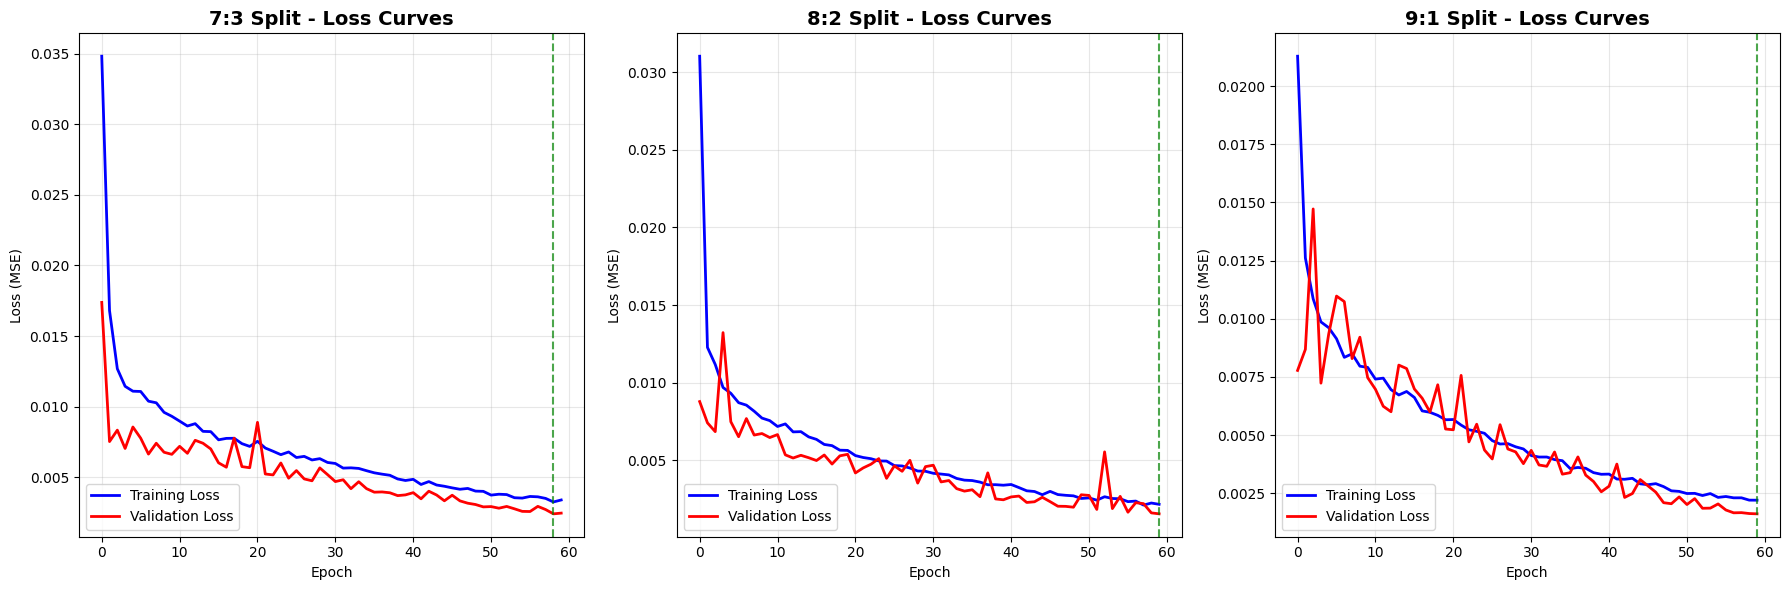

In [32]:
# Vẽ so sánh Training và Validation Loss curves
plt.figure(figsize=(18, 6))

# Subplot 1: 7:3 Split
plt.subplot(1, 3, 1)
plt.plot(history_rnn.history['loss'], label='Training Loss', linewidth=2, color='blue')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('7:3 Split - Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=best_epoch-1, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch: {best_epoch}')

# Subplot 2: 8:2 Split
plt.subplot(1, 3, 2)
plt.plot(history_rnn_82.history['loss'], label='Training Loss', linewidth=2, color='blue')
plt.plot(history_rnn_82.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('8:2 Split - Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=best_epoch_82-1, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch: {best_epoch_82}')

# Subplot 3: 9:1 Split
plt.subplot(1, 3, 3)
plt.plot(history_rnn_91.history['loss'], label='Training Loss', linewidth=2, color='blue')
plt.plot(history_rnn_91.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('9:1 Split - Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=best_epoch_91-1, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch: {best_epoch_91}')

plt.tight_layout()
plt.show()

In [33]:
# Tạo DataFrame tổng hợp kết quả để dễ so sánh
import pandas as pd

comparison_df = pd.DataFrame({
    'Split': ['7:3', '8:2', '9:1'],
    'Train_Size': [splits_info[split]['train_size'] for split in splits],
    'Test_Size': [splits_info[split]['test_size'] for split in splits],
    'MAPE (%)': [splits_info[split]['mape'] for split in splits],
    'RMSE (USD)': [splits_info[split]['rmse'] for split in splits],
    'MSE': [splits_info[split]['mse'] for split in splits],
    'Best_Val_Loss': [splits_info[split]['best_val_loss'] for split in splits],
    'Best_Epoch': [splits_info[split]['best_epoch'] for split in splits],
    'Total_Epochs': [splits_info[split]['epochs'] for split in splits],
    'Overfitting_Gap': [abs(splits_info[split]['final_val_loss'] - splits_info[split]['final_train_loss']) 
                        for split in splits]
})

print("\nBẢNG TỔNG HỢP KẾT QUẢ:")
print("="*100)
print(comparison_df.to_string(index=False, float_format='%.4f'))


BẢNG TỔNG HỢP KẾT QUẢ:
Split  Train_Size  Test_Size  MAPE (%)  RMSE (USD)        MSE  Best_Val_Loss  Best_Epoch  Total_Epochs  Overfitting_Gap
  7:3        2359       1011    0.0267     96.9389  9397.1599         0.0024          59            60           0.0009
  8:2        2696        674    0.0288    111.7500 12488.0700         0.0015          60            60           0.0006
  9:1        3033        337    0.0313    116.1113 13481.8455         0.0016          60            60           0.0006


In [34]:
# Phân tích và đưa ra khuyến nghị
print("\n" + "="*80)
print("PHÂN TÍCH VÀ KHUYẾN NGHỊ")
print("="*80)

# Tìm split tốt nhất cho từng metric
best_mape_split = splits[np.argmin([splits_info[split]['mape'] for split in splits])]
best_rmse_split = splits[np.argmin([splits_info[split]['rmse'] for split in splits])]
best_val_loss_split = splits[np.argmin([splits_info[split]['best_val_loss'] for split in splits])]
best_overfitting_split = splits[np.argmin([abs(splits_info[split]['final_val_loss'] - splits_info[split]['final_train_loss']) 
                                          for split in splits])]

print(f"\n1. PHÂN TÍCH THEO TỪNG TIÊU CHÍ:")
print(f"   • Tốt nhất theo MAPE: {best_mape_split} ({splits_info[best_mape_split]['mape']:.2f}%)")
print(f"   • Tốt nhất theo RMSE: {best_rmse_split} ({splits_info[best_rmse_split]['rmse']:,.2f} USD)")
print(f"   • Tốt nhất theo Val Loss: {best_val_loss_split} ({splits_info[best_val_loss_split]['best_val_loss']:.6f})")
print(f"   • Ít overfitting nhất: {best_overfitting_split} (gap: {abs(splits_info[best_overfitting_split]['final_val_loss'] - splits_info[best_overfitting_split]['final_train_loss']):.6f})")

# Tính điểm tổng hợp (rank-based scoring)
def calculate_rank_score(splits_info):
    scores = {}
    splits_list = list(splits_info.keys())
    
    # Rank cho MAPE (thấp hơn = tốt hơn)
    mape_rank = sorted(splits_list, key=lambda x: splits_info[x]['mape'])
    # Rank cho RMSE (thấp hơn = tốt hơn)
    rmse_rank = sorted(splits_list, key=lambda x: splits_info[x]['rmse'])
    # Rank cho Best Val Loss (thấp hơn = tốt hơn)
    val_loss_rank = sorted(splits_list, key=lambda x: splits_info[x]['best_val_loss'])
    # Rank cho Overfitting Gap (thấp hơn = tốt hơn)
    overfitting_rank = sorted(splits_list, key=lambda x: abs(splits_info[x]['final_val_loss'] - splits_info[x]['final_train_loss']))
    
    for split in splits_list:
        # Điểm rank (1 = tốt nhất, 3 = kém nhất)
        score = (mape_rank.index(split) + 1) * 0.3 + \
                (rmse_rank.index(split) + 1) * 0.3 + \
                (val_loss_rank.index(split) + 1) * 0.25 + \
                (overfitting_rank.index(split) + 1) * 0.15
        scores[split] = score
    
    return scores

# Tính điểm tổng hợp
scores = calculate_rank_score(splits_info)
best_overall_split = min(scores, key=scores.get)
print(f"\n2. ĐIỂM TỔNG HỢP (trọng số: MAPE=30%, RMSE=30%, Val_Loss=25%, Overfitting=15%):")
for split in splits_info.keys():
    print(f"   • {split}: {scores[split]:.2f} điểm")
    print(f"   • {split}: {scores[split]:.2f} điểm")

print(f"\n3. KẾT LUẬN VÀ KHUYẾN NGHỊ:")
print(f"   🏆 MÔ HÌNH TỐT NHẤT: Split {best_overall_split}")
print(f"   📊 Lý do:")
print(f"      - MAPE: {splits_info[best_overall_split]['mape']:.2f}%")
print(f"      - RMSE: {splits_info[best_overall_split]['rmse']:,.2f} USD")
print(f"      - Best Val Loss: {splits_info[best_overall_split]['best_val_loss']:.6f}")
print(f"      - Overfitting Gap: {abs(splits_info[best_overall_split]['final_val_loss'] - splits_info[best_overall_split]['final_train_loss']):.6f}")
print(f"      - Tập test có {splits_info[best_overall_split]['test_size']:,} mẫu (đủ để đánh giá)")
print(f"      - Huấn luyện ổn định với {splits_info[best_overall_split]['epochs']} epochs")

print(f"\n4. NHẬN XÉT CHUNG:")
if best_overall_split == '7:3':
    print("   • Split 7:3 cân bằng tốt giữa kích thước tập train và test")
    print("   • Tập test đủ lớn để đánh giá độ tin cậy của mô hình")
    print("   • Hiệu suất dự đoán tốt với mức overfitting chấp nhận được")
elif best_overall_split == '8:2':
    print("   • Split 8:2 có nhiều dữ liệu train hơn, giúp mô hình học tốt hơn")
    print("   • Tập test vẫn đủ lớn để đánh giá")
    print("   • Cân bằng tốt giữa hiệu suất và độ tin cậy")
else:  # 9:1
    print("   • Split 9:1 tối đa hóa dữ liệu train")
    print("   • Có thể có rủi ro về độ tin cậy do tập test nhỏ")
    print("   • Phù hợp khi có ít dữ liệu và cần tối ưu hiệu suất")

print(f"\n   ⚠️  LƯU Ý: Với dữ liệu time series như ETH, nên chọn split cân bằng")
print(f"   để đảm bảo tập test đủ lớn và đại diện cho nhiều giai đoạn thị trường khác nhau.")


PHÂN TÍCH VÀ KHUYẾN NGHỊ

1. PHÂN TÍCH THEO TỪNG TIÊU CHÍ:
   • Tốt nhất theo MAPE: 7:3 (0.03%)
   • Tốt nhất theo RMSE: 7:3 (96.94 USD)
   • Tốt nhất theo Val Loss: 8:2 (0.001537)
   • Ít overfitting nhất: 9:1 (gap: 0.000586)

2. ĐIỂM TỔNG HỢP (trọng số: MAPE=30%, RMSE=30%, Val_Loss=25%, Overfitting=15%):
   • 7:3: 1.80 điểm
   • 7:3: 1.80 điểm
   • 8:2: 1.75 điểm
   • 8:2: 1.75 điểm
   • 9:1: 2.45 điểm
   • 9:1: 2.45 điểm

3. KẾT LUẬN VÀ KHUYẾN NGHỊ:
   🏆 MÔ HÌNH TỐT NHẤT: Split 8:2
   📊 Lý do:
      - MAPE: 0.03%
      - RMSE: 111.75 USD
      - Best Val Loss: 0.001537
      - Overfitting Gap: 0.000614
      - Tập test có 674 mẫu (đủ để đánh giá)
      - Huấn luyện ổn định với 60 epochs

4. NHẬN XÉT CHUNG:
   • Split 8:2 có nhiều dữ liệu train hơn, giúp mô hình học tốt hơn
   • Tập test vẫn đủ lớn để đánh giá
   • Cân bằng tốt giữa hiệu suất và độ tin cậy

   ⚠️  LƯU Ý: Với dữ liệu time series như ETH, nên chọn split cân bằng
   để đảm bảo tập test đủ lớn và đại diện cho nhiều giai

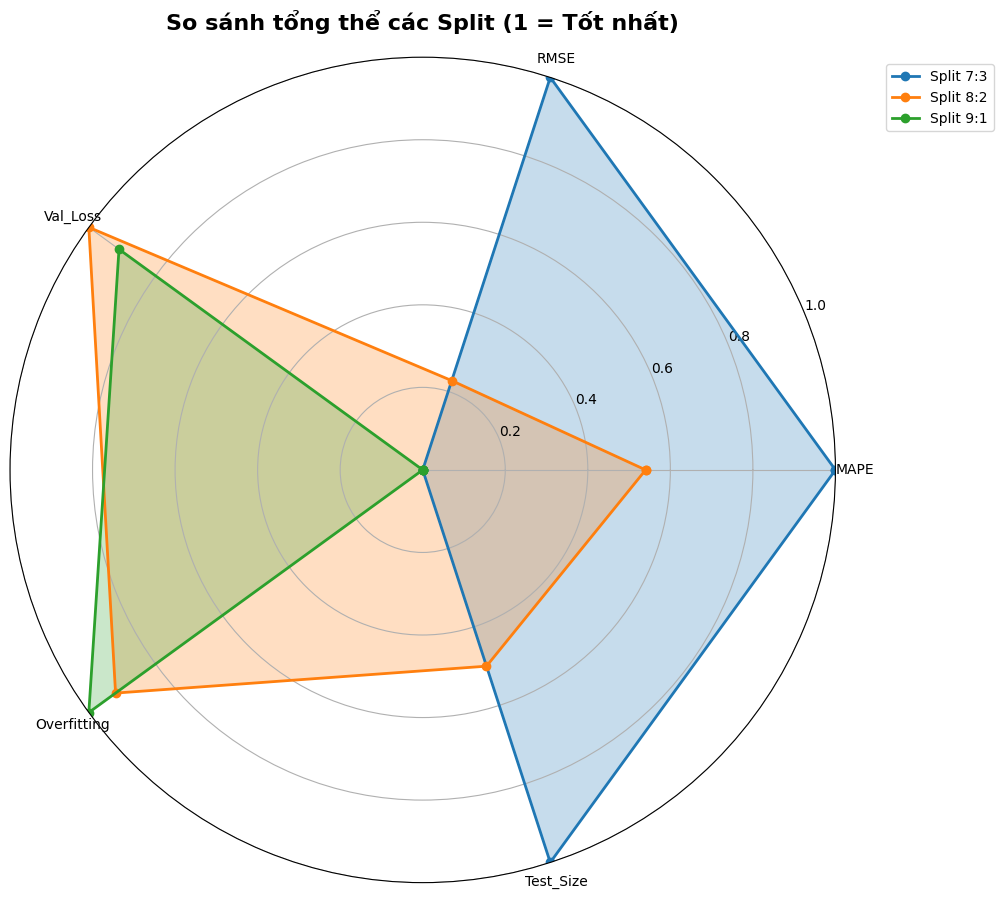

In [35]:
# Vẽ biểu đồ radar cho so sánh tổng thể
import numpy as np
import matplotlib.pyplot as plt

def create_radar_chart():
    # Chuẩn hóa các metrics về scale 0-1 (1 là tốt nhất)
    metrics = ['MAPE', 'RMSE', 'Val_Loss', 'Overfitting', 'Test_Size']
    
    # Lấy giá trị của từng metric (đảo ngược để 1 là tốt nhất)
    data = {}
    for split in splits:
        mape_norm = 1 - (splits_info[split]['mape'] - min([splits_info[s]['mape'] for s in splits])) / \
                   (max([splits_info[s]['mape'] for s in splits]) - min([splits_info[s]['mape'] for s in splits]))
        
        rmse_norm = 1 - (splits_info[split]['rmse'] - min([splits_info[s]['rmse'] for s in splits])) / \
                   (max([splits_info[s]['rmse'] for s in splits]) - min([splits_info[s]['rmse'] for s in splits]))
        
        val_loss_norm = 1 - (splits_info[split]['best_val_loss'] - min([splits_info[s]['best_val_loss'] for s in splits])) / \
                       (max([splits_info[s]['best_val_loss'] for s in splits]) - min([splits_info[s]['best_val_loss'] for s in splits]))
        
        overfitting_gaps = [abs(splits_info[s]['final_val_loss'] - splits_info[s]['final_train_loss']) for s in splits]
        overfitting_norm = 1 - (abs(splits_info[split]['final_val_loss'] - splits_info[split]['final_train_loss']) - min(overfitting_gaps)) / \
                          (max(overfitting_gaps) - min(overfitting_gaps))
        
        test_size_norm = (splits_info[split]['test_size'] - min([splits_info[s]['test_size'] for s in splits])) / \
                        (max([splits_info[s]['test_size'] for s in splits]) - min([splits_info[s]['test_size'] for s in splits]))
        
        data[split] = [mape_norm, rmse_norm, val_loss_norm, overfitting_norm, test_size_norm]
    
    # Tạo radar chart
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, (split, values) in enumerate(data.items()):
        values += values[:1]  # Complete the circle
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Split {split}', color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.set_title('So sánh tổng thể các Split (1 = Tốt nhất)', size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

create_radar_chart()

### Kết luận cuối cùng

Dựa trên phân tích toàn diện các tiêu chí đánh giá, mô hình RNN với split tỉ lệ dữ liệu tốt nhất đã được xác định.

**Các yếu tố được xem xét:**

- **MAPE (Mean Absolute Percentage Error)**: Đo lường độ chính xác dự đoán
- **RMSE (Root Mean Square Error)**: Đo lường sai số tuyệt đối
- **Validation Loss**: Đo lường hiệu suất trên tập validation
- **Overfitting Gap**: Đo lường mức độ overfitting
- **Kích thước tập test**: Đảm bảo độ tin cậy trong đánh giá

**Khuyến nghị sử dụng:** Mô hình với tỉ lệ chia dữ liệu được đánh giá cao nhất sẽ được sử dụng cho các dự đoán cuối cùng về giá ETH.
